In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from skimage.transform import resize
from sklearn.model_selection import train_test_split
import json
from tqdm import tqdm
import matplotlib.pyplot as plt
import Levenshtein as lev
import os
import gc

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

In [2]:
seed = np.random.randint(50000)
print(seed)
seed = 35567
tf.random.set_seed(seed)

4685


# Data loading

#### Here I use new tokens for padding, start and end of sentences. (Capitals are good since the original phrases have only lower case letters, besides numbers and various signs).

In [3]:
pad_token = 'P'
start_token = 'S'
end_token = 'E'
pad_token_idx = 59
start_token_idx = 60
end_token_idx = 61

In [4]:
with open ("/kaggle/input/asl-fingerspelling/character_to_prediction_index.json", "r") as f:
    char_to_num = json.load(f)

char_to_num[pad_token] = pad_token_idx
char_to_num[start_token] = start_token_idx
char_to_num[end_token] = end_token_idx
num_to_char = {j:i for i,j in char_to_num.items()}

inpdir = "/kaggle/input/asl-fingerspelling"
df = pd.read_csv(f'{inpdir}/train.csv')

LPOSE = [13, 15, 17, 19, 21]
RPOSE = [14, 16, 18, 20, 22]
POSE = LPOSE + RPOSE

RHAND_LBLS = [f'x_right_hand_{i}' for i in range(21)] + [f'y_right_hand_{i}' for i in range(21)] + [f'z_right_hand_{i}' for i in range(21)]
LHAND_LBLS = [ f'x_left_hand_{i}' for i in range(21)] + [ f'y_left_hand_{i}' for i in range(21)] + [ f'z_left_hand_{i}' for i in range(21)]
POSE_LBLS = [f'x_pose_{i}' for i in POSE] + [f'y_pose_{i}' for i in POSE] + [f'z_pose_{i}' for i in POSE]

X = [f'x_right_hand_{i}' for i in range(21)] + [f'x_left_hand_{i}' for i in range(21)] + [f'x_pose_{i}' for i in POSE]
Y = [f'y_right_hand_{i}' for i in range(21)] + [f'y_left_hand_{i}' for i in range(21)] + [f'y_pose_{i}' for i in POSE]
Z = [f'z_right_hand_{i}' for i in range(21)] + [f'z_left_hand_{i}' for i in range(21)] + [f'z_pose_{i}' for i in POSE]

SEL_COLS = X + Y + Z
FRAME_LEN = 128

X_IDX = [i for i, col in enumerate(SEL_COLS)  if "x_" in col]
Y_IDX = [i for i, col in enumerate(SEL_COLS)  if "y_" in col]
Z_IDX = [i for i, col in enumerate(SEL_COLS)  if "z_" in col]

RHAND_IDX = [i for i, col in enumerate(SEL_COLS)  if "right" in col]
LHAND_IDX = [i for i, col in enumerate(SEL_COLS)  if  "left" in col]
RPOSE_IDX = [i for i, col in enumerate(SEL_COLS)  if  "pose" in col and int(col[-2:]) in RPOSE]
LPOSE_IDX = [i for i, col in enumerate(SEL_COLS)  if  "pose" in col and int(col[-2:]) in LPOSE]

In [5]:
def resize_pad(x):
    if tf.shape(x)[0] < FRAME_LEN:
        x = tf.pad(x, ([[0, FRAME_LEN-tf.shape(x)[0]], [0, 0], [0, 0]]))
    else:
        x = tf.image.resize(x, (FRAME_LEN, tf.shape(x)[1]))
    return x

def pre_process(x):
    rhand = tf.gather(x, RHAND_IDX, axis=1)
    lhand = tf.gather(x, LHAND_IDX, axis=1)
    rpose = tf.gather(x, RPOSE_IDX, axis=1)
    lpose = tf.gather(x, LPOSE_IDX, axis=1)
    
    rnan_idx = tf.reduce_any(tf.math.is_nan(rhand), axis=1)
    lnan_idx = tf.reduce_any(tf.math.is_nan(lhand), axis=1)
    
    rnans = tf.math.count_nonzero(rnan_idx)
    lnans = tf.math.count_nonzero(lnan_idx)
    
    # For dominant hand
    if rnans > lnans:
        hand = lhand
        pose = lpose
        
        hand_x = hand[:, 0*(len(LHAND_IDX)//3) : 1*(len(LHAND_IDX)//3)]
        hand_y = hand[:, 1*(len(LHAND_IDX)//3) : 2*(len(LHAND_IDX)//3)]
        hand_z = hand[:, 2*(len(LHAND_IDX)//3) : 3*(len(LHAND_IDX)//3)]
        hand = tf.concat([1-hand_x, hand_y, hand_z], axis=1)
        
        pose_x = pose[:, 0*(len(LPOSE_IDX)//3) : 1*(len(LPOSE_IDX)//3)]
        pose_y = pose[:, 1*(len(LPOSE_IDX)//3) : 2*(len(LPOSE_IDX)//3)]
        pose_z = pose[:, 2*(len(LPOSE_IDX)//3) : 3*(len(LPOSE_IDX)//3)]
        pose = tf.concat([1-pose_x, pose_y, pose_z], axis=1)
    else:
        hand = rhand
        pose = rpose
    
    hand_x = hand[:, 0*(len(LHAND_IDX)//3) : 1*(len(LHAND_IDX)//3)]
    hand_y = hand[:, 1*(len(LHAND_IDX)//3) : 2*(len(LHAND_IDX)//3)]
    hand_z = hand[:, 2*(len(LHAND_IDX)//3) : 3*(len(LHAND_IDX)//3)]
    hand = tf.concat([hand_x[..., tf.newaxis], hand_y[..., tf.newaxis], hand_z[..., tf.newaxis]], axis=-1)
    
    mean = tf.math.reduce_mean(hand, axis=1)[:, tf.newaxis, :]
    std = tf.math.reduce_std(hand, axis=1)[:, tf.newaxis, :]
    hand = (hand - mean) / std

    pose_x = pose[:, 0*(len(LPOSE_IDX)//3) : 1*(len(LPOSE_IDX)//3)]
    pose_y = pose[:, 1*(len(LPOSE_IDX)//3) : 2*(len(LPOSE_IDX)//3)]
    pose_z = pose[:, 2*(len(LPOSE_IDX)//3) : 3*(len(LPOSE_IDX)//3)]
    pose = tf.concat([pose_x[..., tf.newaxis], pose_y[..., tf.newaxis], pose_z[..., tf.newaxis]], axis=-1)
    
    x = tf.concat([hand, pose], axis=1)
    x = resize_pad(x)
    
    x = tf.where(tf.math.is_nan(x), tf.zeros_like(x), x)
    x = tf.reshape(x, (FRAME_LEN, len(LHAND_IDX) + len(LPOSE_IDX)))
    return x

In [6]:
table = tf.lookup.StaticHashTable(
    initializer=tf.lookup.KeyValueTensorInitializer(
        keys=list(char_to_num.keys()),
        values=list(char_to_num.values()),
    ),
    default_value=tf.constant(-1),
    name="class_weight"
)

def preprocess_fn(landmarks, phrase):
    phrase = start_token + phrase + end_token
    phrase = tf.strings.bytes_split(phrase)
    phrase = table.lookup(phrase)
    phrase = tf.pad(phrase, paddings=[[0, 64 - tf.shape(phrase)[0]]], mode = 'CONSTANT',
                    constant_values = pad_token_idx)
    return pre_process(landmarks), phrase

def decode_fn(record_bytes):
    schema = {COL: tf.io.VarLenFeature(dtype=tf.float32) for COL in SEL_COLS}
    schema["phrase"] = tf.io.FixedLenFeature([], dtype=tf.string)
    features = tf.io.parse_single_example(record_bytes, schema)
    phrase = features["phrase"]
    landmarks = ([tf.sparse.to_dense(features[COL]) for COL in SEL_COLS])
    landmarks = tf.transpose(landmarks)
    
    return landmarks, phrase

inpdir = "/kaggle/input/aslfr-parquets-to-tfrecords-cleaned"
tffiles = df.file_id.map(lambda x: f'{inpdir}/tfds/{x}.tfrecord').unique()

batch_size = 32
val_len = int(0.05 * len(tffiles))

train_dataset = tf.data.TFRecordDataset(tffiles[val_len:]).map(decode_fn).map(preprocess_fn).shuffle(30000, reshuffle_each_iteration=True).batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)
val_dataset = tf.data.TFRecordDataset(tffiles[:val_len]).map(decode_fn).map(preprocess_fn).batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)

# The model

#### Here I implemented proper positional embeddings for both the encoder and the decoder.

In [7]:
class TokenEmbedding(layers.Layer):
    def __init__(self, num_vocab=1000, maxlen=100, num_hid=64):
        super().__init__()
        self.num_hid = num_hid
        self.emb = tf.keras.layers.Embedding(num_vocab, num_hid)
        #self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=num_hid)
        '''
        self.pos_emb = tf.math.divide(
            self.positional_encoding(maxlen-1, num_hid),
            tf.math.sqrt(tf.cast(num_hid, tf.float32)))
        '''
        self.pos_emb = self.positional_encoding(maxlen-1, num_hid)

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        x = self.emb(x)
        x = tf.math.multiply(x, tf.math.sqrt(tf.cast(self.num_hid, tf.float32)))
        '''
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        return x + positions
        '''
        return x + self.pos_emb[:maxlen, :]
    
    def positional_encoding(self, maxlen, num_hid):
        depth = num_hid/2
        positions = tf.range(maxlen, dtype = tf.float32)[..., tf.newaxis]
        depths = tf.range(depth, dtype = tf.float32)[np.newaxis, :]/depth
        angle_rates = tf.math.divide(1, tf.math.pow(tf.cast(10000, tf.float32), depths))
        angle_rads = tf.linalg.matmul(positions, angle_rates)
        pos_encoding = tf.concat(
          [tf.math.sin(angle_rads), tf.math.cos(angle_rads)],
          axis=-1) 
        return pos_encoding


class LandmarkEmbedding(layers.Layer):
    def __init__(self, num_hid=64, maxlen=100):
        super().__init__()
        self.conv1 = tf.keras.layers.Conv1D(
            num_hid, 11, padding="same", activation="relu"
        )
        self.conv2 = tf.keras.layers.Conv1D(
            num_hid, 11, padding="same", activation="relu"
        )
        self.conv3 = tf.keras.layers.Conv1D(
            num_hid, 11, padding="same", activation="relu"
        )
        self.pos_emb = self.positional_encoding(maxlen, num_hid)
        self.maxlen = maxlen
        self.num_hid = num_hid

    def call(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        
        x = tf.math.multiply(x, tf.math.sqrt(tf.cast(self.num_hid, tf.float32)))
        x = x + self.pos_emb
        
        return x
    
    def positional_encoding(self, maxlen, num_hid):
        depth = num_hid/2
        positions = tf.range(maxlen, dtype = tf.float32)[..., tf.newaxis]
        depths = tf.range(depth, dtype = tf.float32)[np.newaxis, :]/depth
        angle_rates = tf.math.divide(1, tf.math.pow(tf.cast(10000, tf.float32), depths))
        angle_rads = tf.linalg.matmul(positions, angle_rates)
        pos_encoding = tf.concat(
          [tf.math.sin(angle_rads), tf.math.cos(angle_rads)],
          axis=-1) 
        return pos_encoding

In [8]:
class TransformerEncoder(layers.Layer):
    def __init__(self, embed_dim, num_heads, feed_forward_dim, rate=0.1):
        super().__init__()
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = keras.Sequential(
            [
                layers.Dense(feed_forward_dim, activation="relu"),
                layers.Dense(embed_dim),
            ]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

#### Here I added the training flag to the TransformerDecoder's Dropout layers.

In [9]:
class TransformerDecoder(layers.Layer):
    def __init__(self, embed_dim, num_heads, feed_forward_dim, dropout_rate=0.1):
        super().__init__()
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm3 = layers.LayerNormalization(epsilon=1e-6)
        self.self_att = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim
        )
        self.enc_att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.self_dropout = layers.Dropout(0.5)
        self.enc_dropout = layers.Dropout(0.1)
        self.ffn_dropout = layers.Dropout(0.1)
        self.ffn = keras.Sequential(
            [
                layers.Dense(feed_forward_dim, activation="relu"),
                layers.Dense(embed_dim),
            ]
        )

    def causal_attention_mask(self, batch_size, n_dest, n_src, dtype):
        """Masks the upper half of the dot product matrix in self attention.

        This prevents flow of information from future tokens to current token.
        1's in the lower triangle, counting from the lower right corner.
        """
        i = tf.range(n_dest)[:, None]
        j = tf.range(n_src)
        m = i >= j - n_src + n_dest
        mask = tf.cast(m, dtype)
        mask = tf.reshape(mask, [1, n_dest, n_src])
        mult = tf.concat(
            [batch_size[..., tf.newaxis], tf.constant([1, 1], dtype=tf.int32)], 0
        )
        return tf.tile(mask, mult)

    def call(self, enc_out, target, training):
        input_shape = tf.shape(target)
        batch_size = input_shape[0]
        seq_len = input_shape[1]
        causal_mask = self.causal_attention_mask(batch_size, seq_len, seq_len, tf.bool)
        target_att = self.self_att(target, target, attention_mask=causal_mask)
        target_norm = self.layernorm1(target + self.self_dropout(target_att, training = training))
        enc_out = self.enc_att(target_norm, enc_out)
        enc_out_norm = self.layernorm2(self.enc_dropout(enc_out, training = training) + target_norm)
        ffn_out = self.ffn(enc_out_norm)
        ffn_out_norm = self.layernorm3(enc_out_norm + self.ffn_dropout(ffn_out, training = training))
        return ffn_out_norm

#### Here I made the passing of the training flag explicit.

In [10]:
class Transformer(keras.Model):
    def __init__(
        self,
        num_hid=64,
        num_head=2,
        num_feed_forward=128,
        source_maxlen=100,
        target_maxlen=100,
        num_layers_enc=4,
        num_layers_dec=1,
        num_classes=60,
    ):
        super().__init__()
        self.loss_metric = keras.metrics.Mean(name="loss")
        self.num_layers_enc = num_layers_enc
        self.num_layers_dec = num_layers_dec
        self.target_maxlen = target_maxlen
        self.num_classes = num_classes

        self.enc_input = LandmarkEmbedding(num_hid=num_hid, maxlen=source_maxlen)
        self.dec_input = TokenEmbedding(
            num_vocab=num_classes, maxlen=target_maxlen, num_hid=num_hid
        )

        self.encoder = keras.Sequential(
            [self.enc_input]
            + [
                TransformerEncoder(num_hid, num_head, num_feed_forward)
                for _ in range(num_layers_enc)
            ]
        )

        for i in range(num_layers_dec):
            setattr(
                self,
                f"dec_layer_{i}",
                TransformerDecoder(num_hid, num_head, num_feed_forward),
            )

        self.classifier = layers.Dense(num_classes)

    def decode(self, enc_out, target, training):
        y = self.dec_input(target)
        for i in range(self.num_layers_dec):
            y = getattr(self, f"dec_layer_{i}")(enc_out, y, training)
        return y

    def call(self, inputs, training):
        source = inputs[0]
        target = inputs[1]
        x = self.encoder(source, training)
        y = self.decode(x, target, training)
        return self.classifier(y)

    @property
    def metrics(self):
        return [self.loss_metric]

    def train_step(self, batch):
        """Processes one batch inside model.fit()."""
        source = batch[0]
        target = batch[1]

        input_shape = tf.shape(target)
        batch_size = input_shape[0]
        
        dec_input = target[:, :-1]
        dec_target = target[:, 1:]
        with tf.GradientTape() as tape:
            preds = self([source, dec_input])
            one_hot = tf.one_hot(dec_target, depth=self.num_classes)
            mask = tf.math.logical_not(tf.math.equal(dec_target, pad_token_idx))
            loss = self.compiled_loss(one_hot, preds, sample_weight=mask)
        trainable_vars = self.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))
        self.loss_metric.update_state(loss)
        return {"loss": self.loss_metric.result()}

    def test_step(self, batch):        
        source = batch[0]
        target = batch[1]

        input_shape = tf.shape(target)
        batch_size = input_shape[0]
        
        dec_input = target[:, :-1]
        dec_target = target[:, 1:]
        preds = self([source, dec_input])
        one_hot = tf.one_hot(dec_target, depth=self.num_classes)
        mask = tf.math.logical_not(tf.math.equal(dec_target, pad_token_idx))
        loss = self.compiled_loss(one_hot, preds, sample_weight=mask)
        self.loss_metric.update_state(loss)
        return {"loss": self.loss_metric.result()}

    def generate(self, source, target_start_token_idx):
        """Performs inference over one batch of inputs using greedy decoding."""
        bs = tf.shape(source)[0]
        enc = self.encoder(source, training = False)
        dec_input = tf.ones((bs, 1), dtype=tf.int32) * target_start_token_idx
        dec_logits = []
        for i in range(self.target_maxlen - 1):
            dec_out = self.decode(enc, dec_input, training = False)
            logits = self.classifier(dec_out)
            logits = tf.argmax(logits, axis=-1, output_type=tf.int32)
            last_logit = logits[:, -1][..., tf.newaxis]
            dec_logits.append(last_logit)
            dec_input = tf.concat([dec_input, last_logit], axis=-1)
        return dec_input

In [11]:
batch = next(iter(val_dataset))
idx_to_char = list(char_to_num.keys())

model = Transformer(
    num_hid=200,
    num_head=4,
    num_feed_forward=400,
    source_maxlen = FRAME_LEN,
    target_maxlen=64,
    num_layers_enc=2,
    num_layers_dec=1,
    num_classes=62,
)


loss_fn = tf.keras.losses.CategoricalCrossentropy(from_logits=True, label_smoothing=0.1)


optimizer = keras.optimizers.Adam(0.0001)
model.compile(optimizer=optimizer, loss=loss_fn)

In [12]:
%%time
history = model.fit(train_dataset, verbose = 2, validation_data=val_dataset, epochs=13)

Epoch 1/13
1520/1520 - 179s - loss: 0.7875 - val_loss: 0.6420 - 179s/epoch - 118ms/step
Epoch 2/13
1520/1520 - 135s - loss: 0.5734 - val_loss: 0.5348 - 135s/epoch - 89ms/step
Epoch 3/13
1520/1520 - 149s - loss: 0.5108 - val_loss: 0.5067 - 149s/epoch - 98ms/step
Epoch 4/13
1520/1520 - 129s - loss: 0.4818 - val_loss: 0.4843 - 129s/epoch - 85ms/step
Epoch 5/13
1520/1520 - 153s - loss: 0.4624 - val_loss: 0.4699 - 153s/epoch - 101ms/step
Epoch 6/13
1520/1520 - 153s - loss: 0.4480 - val_loss: 0.4605 - 153s/epoch - 101ms/step
Epoch 7/13
1520/1520 - 138s - loss: 0.4364 - val_loss: 0.4557 - 138s/epoch - 91ms/step
Epoch 8/13
1520/1520 - 128s - loss: 0.4263 - val_loss: 0.4524 - 128s/epoch - 84ms/step
Epoch 9/13
1520/1520 - 128s - loss: 0.4178 - val_loss: 0.4460 - 128s/epoch - 84ms/step
Epoch 10/13
1520/1520 - 167s - loss: 0.4101 - val_loss: 0.4501 - 167s/epoch - 110ms/step
Epoch 11/13
1520/1520 - 162s - loss: 0.4027 - val_loss: 0.4461 - 162s/epoch - 107ms/step
Epoch 12/13
1520/1520 - 162s - loss:

In [13]:
print(model.summary())

Model: "transformer"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 landmark_embedding (Landmar  (None, 128, 200)         1052200   
 kEmbedding)                                                     
                                                                 
 token_embedding (TokenEmbed  multiple                 12400     
 ding)                                                           
                                                                 
 sequential_2 (Sequential)   (None, 128, 200)          2660200   
                                                                 
 transformer_decoder (Transf  multiple                 1447000   
 ormerDecoder)                                                   
                                                                 
 dense_6 (Dense)             multiple                  12462     
                                                       

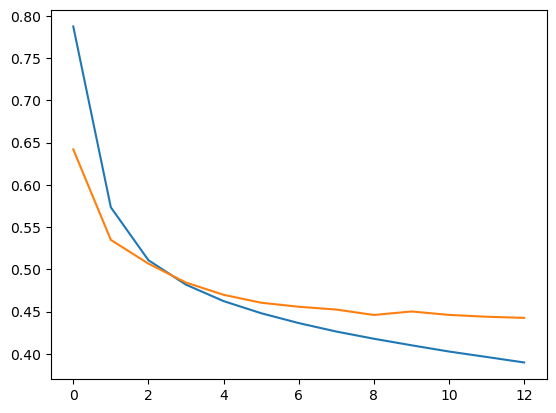

In [14]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

# Validation

In [15]:
batches = [batch for batch in val_dataset]

preds_list = []
ground_truth_list = []

for batch in batches[:1]:
    source = batch[0]
    target = batch[1].numpy()
    bs = tf.shape(source)[0]
    preds = model.generate(source, start_token_idx)
    preds = preds.numpy()

    for i in range(bs):
        target_text = "".join([idx_to_char[_] for _ in target[i, :]])
        ground_truth_list.append(target_text.replace('P', ''))
        prediction = ""
        for idx in preds[i, :]:
            prediction += idx_to_char[idx]
            if idx == end_token_idx:
                break
        preds_list.append(prediction)

for i in range(10):
    print(ground_truth_list[i])
    print(preds_list[i])
    print('\n~~~\n')

S3 creekhouseE
S3 creek houseE

~~~

Sscales/kuhaylahE
Ssecales/duhaporaE

~~~

S1383 william lanierE
S1386 william lanierE

~~~

S988 franklin laneE
S988 funkin planeE

~~~

S6920 northeast 661st roadE
S6920 northeast 61st roadE

~~~

Swww.freem.ne.jpE
Swww.freem.me.itE

~~~

Shttps://jsi.is/hukuokaE
Shttps://jsi.isi.is/hkurokaE

~~~

S239613 stolze streetE
S2396 1a stoll soutE

~~~

S271097 bayshore boulevardE
S271097 bay pore boulevardE

~~~

Sfederico pearsonE
S9 derico pearoonE

~~~



In [16]:
ground_truth_processed = [ground_truth_list[i][1:-1] for i in range(len(ground_truth_list))]
preds_list_processed = [preds_list[i][1:-1] for i in range(len(preds_list))]
lev_dist = [lev.distance(ground_truth_processed[i], preds_list_processed[i]) 
            for i in range(len(preds_list_processed))]
N = [len(phrase) for phrase in ground_truth_processed]

print('Validation score: '+str((np.sum(N) - np.sum(lev_dist))/np.sum(N)))

Validation score: 0.7632933104631218


# TFLiteModel

In [17]:
 class TFLiteModel(tf.Module):
    def __init__(self, model):
        super(TFLiteModel, self).__init__()
        self.target_start_token_idx = start_token_idx
        self.target_end_token_idx = end_token_idx
        # Load the feature generation and main models
        self.model = model
    
    @tf.function(input_signature=[tf.TensorSpec(shape=[None, len(SEL_COLS)], dtype=tf.float32, name='inputs')])
    def __call__(self, inputs, training=False):
        # Preprocess Data
        x = tf.cast(inputs, tf.float32)
        x = x[None]
        x = tf.cond(tf.shape(x)[1] == 0, lambda: tf.zeros((1, 1, len(SEL_COLS))), lambda: tf.identity(x))
        x = x[0]
        x = pre_process(x)
        x = x[None]
        x = self.model.generate(x, self.target_start_token_idx)
        x = x[0]
        idx = tf.argmax(tf.cast(tf.equal(x, self.target_end_token_idx), tf.int32))
        idx = tf.where(tf.math.less(idx, 1), tf.constant(2, dtype=tf.int64), idx)
        x = x[1:idx]
        x = tf.one_hot(x, 59)
        return {'outputs': x}
    
tflitemodel_base = TFLiteModel(model)

In [18]:
model.save_weights("model.h5")

In [19]:
keras_model_converter = tf.lite.TFLiteConverter.from_keras_model(tflitemodel_base)
keras_model_converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS]#, tf.lite.OpsSet.SELECT_TF_OPS]
tflite_model = keras_model_converter.convert()
with open('/kaggle/working/model.tflite', 'wb') as f:
    f.write(tflite_model)
    
infargs = {"selected_columns" : SEL_COLS}

with open('inference_args.json', "w") as json_file:
    json.dump(infargs, json_file)

In [20]:
!zip submission.zip  './model.tflite' './inference_args.json'

  adding: model.tflite (deflated 19%)
  adding: inference_args.json (deflated 85%)


In [21]:
interpreter = tf.lite.Interpreter("model.tflite")

REQUIRED_SIGNATURE = "serving_default"
REQUIRED_OUTPUT = "outputs"

with open ("/kaggle/input/asl-fingerspelling/character_to_prediction_index.json", "r") as f:
    character_map = json.load(f)
rev_character_map = {j:i for i,j in character_map.items()}

found_signatures = list(interpreter.get_signature_list().keys())

if REQUIRED_SIGNATURE not in found_signatures:
    raise KernelEvalException('Required input signature not found.')

prediction_fn = interpreter.get_signature_runner("serving_default")
output = prediction_fn(inputs=batch[0][0])
prediction_str = "".join([rev_character_map.get(s, "") for s in np.argmax(output[REQUIRED_OUTPUT], axis=1)])
print(prediction_str)

/8888/
